## Still Under Minor Work!
### If you liked my work, please give an upvote! I am a beginner and even a single upvote gives me loads of motivation to work on!

# 1. Installation and Imports
I am installing a bunch of modules that would be needed for training on TPUs
Also, installing EfficientNet and ResNet for PyTorch

In [1]:
# Trying out TPUs with PyTorch, still very prone to error tho
# ! curl -s https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# ! python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [2]:
! pip install -q efficientnet_pytorch torchtoolbox resnet_pytorch

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from random import shuffle
import cv2
import warnings
from tqdm.notebook import tqdm

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from resnet_pytorch import ResNet

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GroupKFold

# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.distributed.xla_multiprocessing as xmp

warnings.simplefilter('ignore')
plt.style.use("fivethirtyeight")

For EDA and other analysis, I will be using the already provided SIIM-ISIC Dataset and their CSV files.

In [4]:
data = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
# Append full image path to image_name
IMG_DIR = "../input/siim-isic-melanoma-classification/jpeg/train"
data['image_name'] = data['image_name'].apply(lambda x: os.path.join(IMG_DIR, x+".jpg"))

In [6]:
# Since there are null values in age column, I will replace them with mean of all ages
# Also called 'Mean Imputation'
def impute_age(x):
    if np.isnan(x):
        return int(data['age_approx'].mean())
    else:
        return x

data['age_approx'] = data['age_approx'].apply(impute_age)
# Drop NaN Rows
data = data.dropna()

# 2. EDA
This EDA is by no means extensive, but only a starter one. I plan to improve it as I try out different things.

### 2.1 Target Values Pie Chart

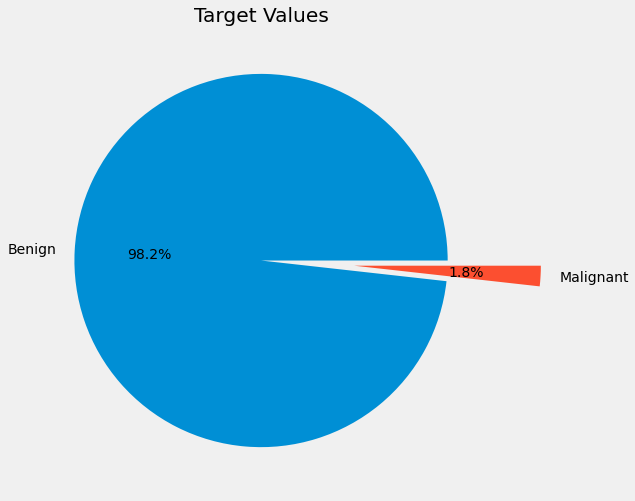

In [7]:
# Target
plt.figure(figsize=(10, 8))
target = [len(data[data['target'] == 0]), len(data[data['target'] == 1])]
labels = ["Benign", "Malignant"]
plt.pie(x=target, labels=labels, explode=[0.0, 0.5], autopct='%1.1f%%')
plt.title("Target Values")
plt.show()

### 2.2 Age Values Distribution
We can note that a good majority of ages in the dataset are between 40-60. One contributing factor to it is that we have replace NaN values in Age column with the mean with is ~48

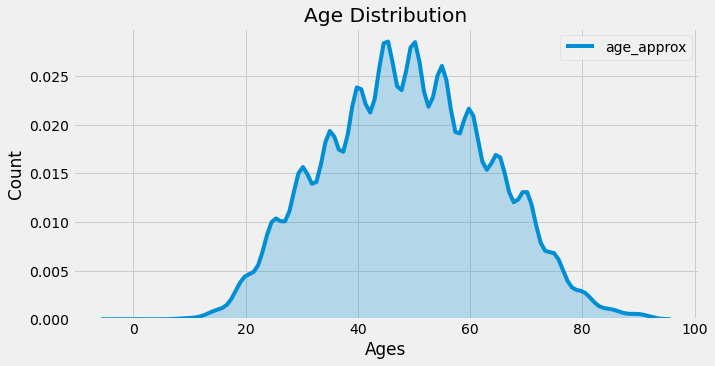

In [8]:
# Age
plt.figure(figsize=(10, 5))
chart = sns.kdeplot(data['age_approx'], shade=True)
plt.title("Age Distribution")
plt.xlabel("Ages")
plt.ylabel("Count")
plt.show()

### 2.3 Sex Values Pie - All Cases
This Pie is for all the cases

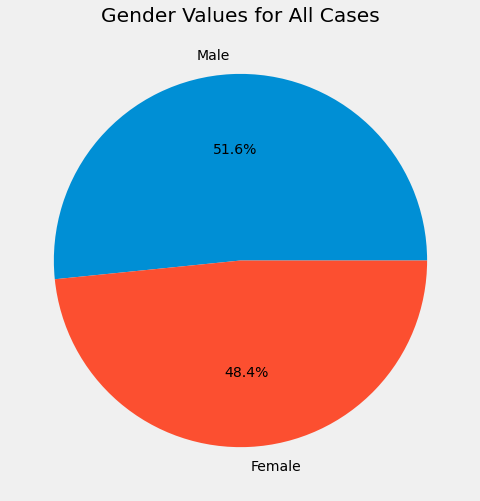

In [9]:
# Sex - all
plt.figure(figsize=(10, 8))
target = [len(data[data['sex'] == 'male']), len(data[data['sex'] == 'female'])]
labels = ["Male", "Female"]
plt.pie(x=target, labels=labels, autopct='%1.1f%%')
plt.title("Gender Values for All Cases")
plt.show()

### 2.4 Sex Values - Malignant Cases
This chart is only for patients that have Malignant Case of Melanoma.
Anyone can be mistaken seeing the pie chart for all cases that gender values are near equally distributed, but that is not the case for malignant

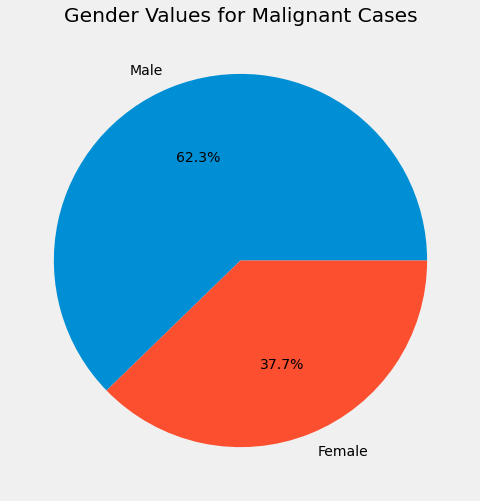

In [10]:
# Sex - malignant
plt.figure(figsize=(10, 8))
target = [len(data.query("sex == 'male' and target == '1'")), len(data.query("sex == 'female' and target == '1'"))]
labels = ["Male", "Female"]
plt.pie(x=target, labels=labels, autopct='%1.1f%%')
plt.title("Gender Values for Malignant Cases")
plt.show()

### 2.5 Site of Focus - All Cases

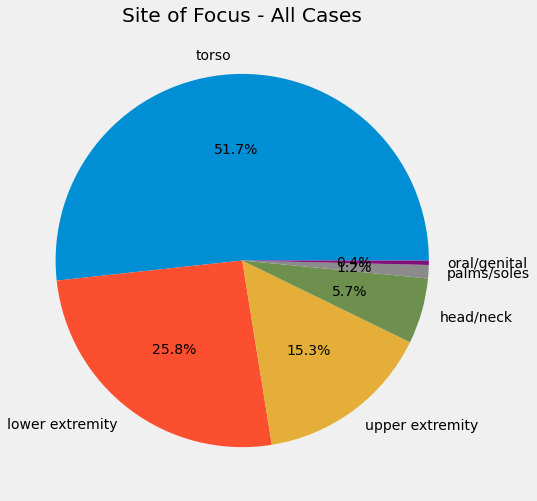

In [11]:
# Site of Focus
plt.figure(figsize=(10, 8))
targets = data['anatom_site_general_challenge'].value_counts().tolist()
labels = dict(data['anatom_site_general_challenge'].value_counts()).keys()
plt.pie(x=targets, labels=labels, autopct='%1.1f%%')
plt.title("Site of Focus - All Cases")
plt.show()

### 2.6 Site of Focus - Malignant Cases Only

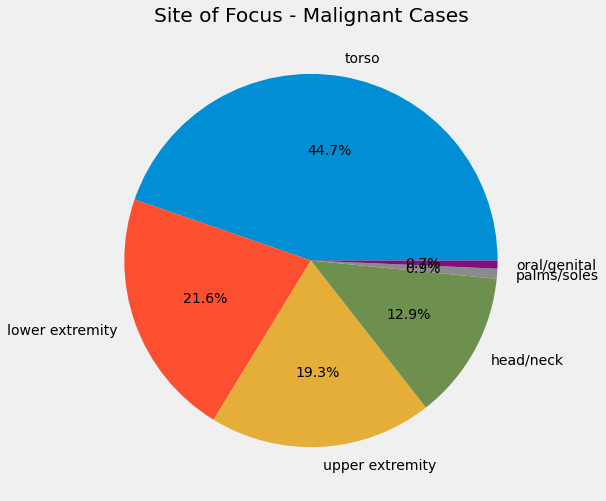

In [12]:
# Site of Focus - Malignant Only
plt.figure(figsize=(10, 8))
targets = data[data['target']==1]['anatom_site_general_challenge'].value_counts().tolist()
labels = dict(data[data['target']==1]['anatom_site_general_challenge'].value_counts()).keys()
plt.pie(x=targets, labels=labels, autopct='%1.1f%%')
plt.title("Site of Focus - Malignant Cases")
plt.show()

### 2.7 Diasnosis with Unknowns
This pie-chart shows the diagnosis including the unknown diagnosis

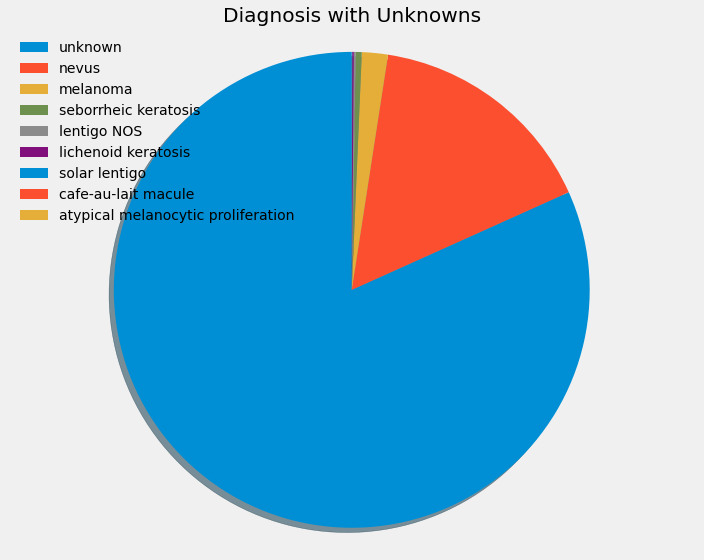

In [13]:
# Diagnosis w/t Unknowns
plt.figure(figsize=(10, 8))
targets = data['diagnosis'].value_counts().tolist()
labels = dict(data['diagnosis'].value_counts()).keys()
patches, texts = plt.pie(targets, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best", frameon=False)
plt.axis('equal')
plt.title("Diagnosis with Unknowns")
plt.tight_layout()
plt.show()

### 2.8 Diagnosis without Unknowns
The Pie-chart of all the diagnosis is dominated by the huge number of unknowns, let's see it without the unknowns

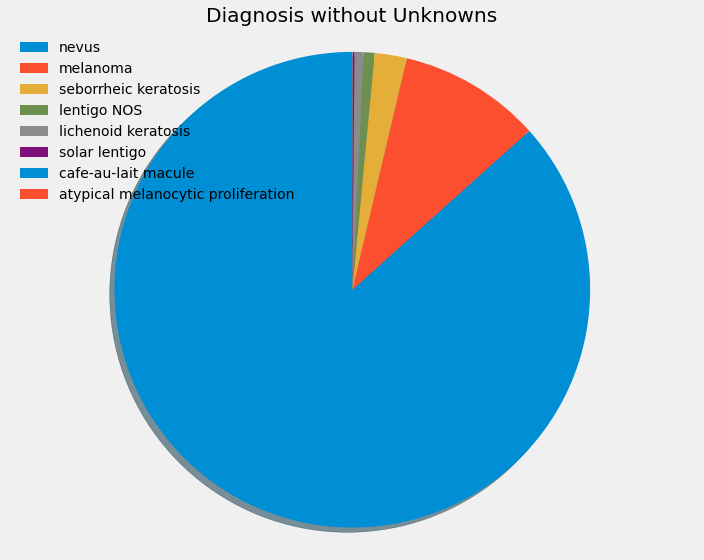

In [14]:
# Diagnosis w/tout Unknonws
plt.figure(figsize=(10, 8))
targets = data['diagnosis'].value_counts().tolist()[1:]
labels = list(dict(data['diagnosis'].value_counts()).keys())[1:]
patches, texts = plt.pie(targets, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best", frameon=False)
plt.axis('equal')
plt.title("Diagnosis without Unknowns")
plt.tight_layout()
plt.show()

### 2.9 Crosstab Heatmap for Diagnosis v/s target

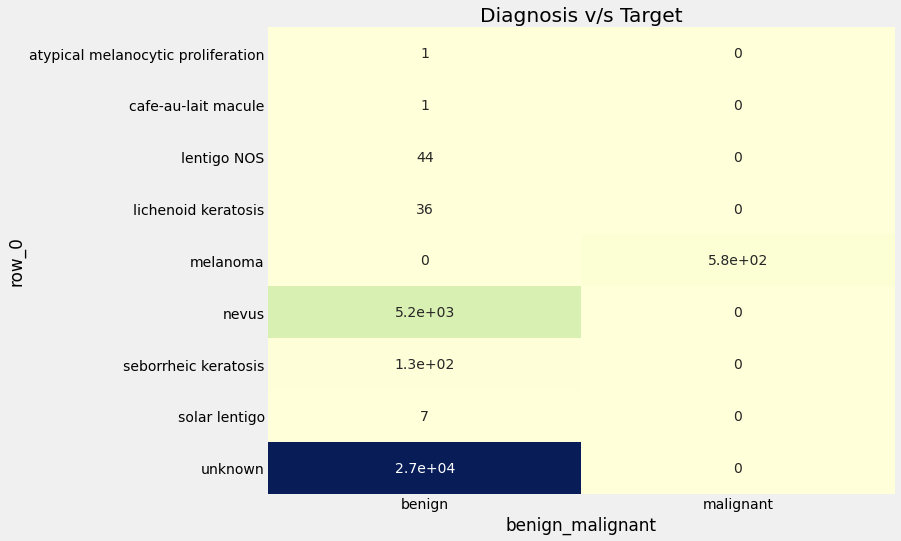

In [15]:
# Crosstab Heatmap
plt.figure(figsize=(10, 8))
data_h = data.drop(['image_name','patient_id','sex','age_approx','anatom_site_general_challenge','target'], axis=1)
cross = pd.crosstab(data['diagnosis'].values, data['benign_malignant'])
sns.heatmap(cross, cmap="YlGnBu", annot=True, cbar=False)
plt.title("Diagnosis v/s Target")
plt.show()

### 2.10 Peek at the Images
Let's take a look at different images in their normal and canny-edge detected forms

In [16]:
def display_images(num, canny=False):
    """
    I modified this function to display canny edges too
    Originally taken from the excellent EDA notebook by Tarun Paparaju
    Here: https://www.kaggle.com/tarunpaparaju/siim-isic-melanoma-eda-pytorch-baseline
    """
    IMG_PATHS = "../input/siim-isic-melanoma-classification/jpeg/train"
    sq_num = np.sqrt(num)
    assert sq_num == int(sq_num)

    sq_num = int(sq_num)
    image_ids = os.listdir(IMG_PATHS)
    shuffle(image_ids)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(10, 10))

    for i in range(sq_num):
        for j in range(sq_num):
            idx = i*sq_num + j
            ax[i, j].axis('off')
            img = cv2.imread(IMG_PATHS + '/' + image_ids[idx])
            if canny:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.Canny(img, 50, 50)
                ax[i, j].imshow(img); ax[i, j].set_title('Canny Image {}'.format(idx), fontsize=12)
            else:
                ax[i, j].imshow(img); ax[i, j].set_title('Normal Image {}'.format(idx), fontsize=12)

    plt.show()

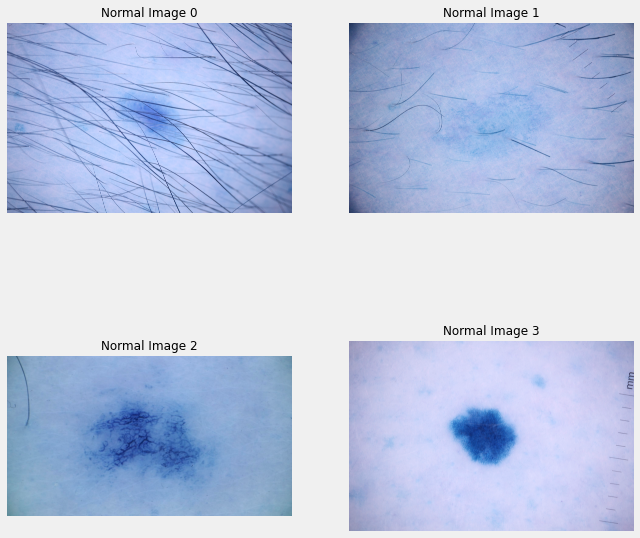

In [17]:
display_images(4, canny=False)

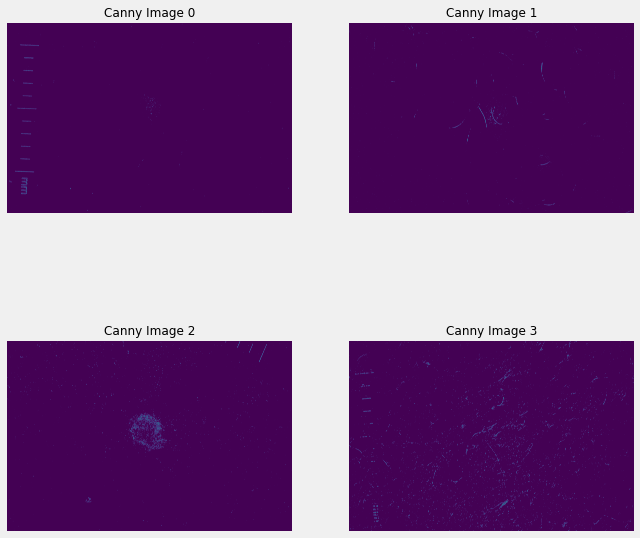

In [18]:
display_images(4, canny=True)

# 3. Modelling

I am currently in the process of trying out different approaches for training. As of now (14/7/20), I am only using Images as features to train the model and not other meta features such as age, sex, etc.

I am beginner and I learned how to do this from [Roman's Kernel](https://www.kaggle.com/nroman/melanoma-pytorch-starter-efficientnet) (Thank you!!)

In [19]:
# Split the data into 5 folds for training
kf = GroupKFold(n_splits=5)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = xm.xla_device()

In [21]:
# I'll be using a different resized dataset for training
data = pd.read_csv("../input/melanoma-external-malignant-256/train_concat.csv")
submission_df = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")

In [22]:
# Remove Meta Features (might use them in a later release)
submission_df = submission_df.drop(['sex', 'age_approx', 'anatom_site_general_challenge'], axis=1)
submission_df['patient_id'] = submission_df['patient_id'].fillna(0)

In [23]:
data = data.drop(['sex', 'age_approx', 'anatom_site_general_challenge'], axis=1)
data['patient_id'] = data['patient_id'].fillna(0)
data.head()

,image_name,patient_id,target
0,ISIC_2637011,IP_7279968,0
1,ISIC_0015719,IP_3075186,0
2,ISIC_0052212,IP_2842074,0
3,ISIC_0068279,IP_6890425,0
4,ISIC_0074268,IP_8723313,0


In [24]:
# Add the complete path to the image_names for ease in loading them
TRAIN_IMG_PATH = "../input/melanoma-external-malignant-256/train/train"
TEST_IMG_PATH = "../input/melanoma-external-malignant-256/test/test"
data['image_name'] = data['image_name'].apply(lambda x: os.path.join(TRAIN_IMG_PATH, x + ".jpg"))
submission_df['image_name'] = submission_df['image_name'].apply(lambda x: os.path.join(TEST_IMG_PATH, x + ".jpg"))

In [25]:
class MelanomaDataset(Dataset):
    """
    Custom Dataset class for loading Melanoma Dataset
    """
    def __init__(self, df, is_train=True, transform=None):
        self.df = df
        self.is_train = is_train
        self.transform = transform
    
    def __getitem__(self, index):
        """
        Get the image path, read it and return it with corresponding label (if is_train=True)
        else return just the image
        """
        self.img_path = self.df.iloc[index]['image_name']
        img = cv2.imread(self.img_path)
        if self.transform:
            img = self.transform(img)
        if self.is_train:
            labl = self.df.iloc[index]['target']
            return img, labl
        else:
            return img
    def __len__(self):
        return len(self.df)

In [26]:
class Network(nn.Module):
    """
    Currently I've only implmented 2 models (EfficientNet and ResNet15)
    
    Friendly warning: DONOT USE RESNET150, IT WILL PROBABLY RESULT IN AN OOM ERROR (OUT OF MEMORY)
    """
    def __init__(self, model_name='eff'):
        super(Network, self).__init__()
        self.model_name = model_name
        if self.model_name == 'eff':
            self.model = EfficientNet.from_pretrained('efficientnet-b1')
            self.model._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
            self.output = nn.Linear(500, 1)
        elif self.model_name == 'res':
            self.model = ResNet.from_pretrained('resnet18')
            self.model.fc = nn.Linear(in_features=512, out_features=500, bias=True)
            self.output = nn.Linear(500, 1)
        
    def forward(self, img):
        img_feat = self.model(img)
        out = self.output(img_feat)
        return out

In [27]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

In [28]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    Microscope(p=0.6),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [29]:
test = MelanomaDataset(
    df=submission_df,
    is_train=False,
    transform=test_transform
)

In [30]:
# Main training loop
epochs = 3
save_model_path = "best_model.pth"

net = Network(model_name="eff")
net = net.to(device)
optim = torch.optim.Adam(net.parameters(), lr=1e-2)
loss_fn = nn.BCEWithLogitsLoss()

for fold_, (train_idx, val_idx) in enumerate(kf.split(X=np.zeros(len(data)), y=data['target'], groups=data['patient_id'].tolist()), 1):
    print("="*20, f"Fold: {fold_}", "="*20)    
    
    # Make the datasets and initialize their respective loaders
    train = MelanomaDataset(
        df=data.iloc[train_idx].reset_index(drop=True),
        is_train=True,
        transform=train_transform
    )
    
    valid = MelanomaDataset(
        df=data.iloc[val_idx].reset_index(drop=True),
        is_train=True,
        transform=train_transform
    )
    
    train_loader = DataLoader(train, batch_size=64, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid, batch_size=64, shuffle=True, num_workers=2)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    
    # For every fold, complete the required number of epochs
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        net.train()
        
        for x, y in train_loader:
            # Convert the x (img) and y (labels) into torch tensors
            x = torch.tensor(x, device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            
            # Training Procedure
            optim.zero_grad()
            z = net(x)
            loss = loss_fn(z, y.unsqueeze(1))
            loss.backward()
            optim.step()
            
            # Calculate the predictions
            pred = torch.round(torch.sigmoid(z))
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()
            epoch_loss += loss.item()
        
        train_acc = correct / len(train_idx)
        
        # Validation Set Evaluation!!!
        net.eval()
        with torch.no_grad():
            val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
            for j, (x_val, y_val) in enumerate(valid_loader):
                x_val = torch.tensor(x_val, device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                val_pred = torch.sigmoid(net(x_val))
                val_preds[j * x_val.shape[0] : j * x_val.shape[0] + x_val.shape[0]] = val_pred
                val_acc = accuracy_score(data.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
                val_roc_auc = roc_auc_score(data.iloc[val_idx]['target'].values, val_preds.cpu())
                scheduler.step(val_roc_auc)
                
            print("-"*10, "Valid Values", "-"*10)
            print(f"Epoch: {epoch+1}/{epochs} | Training Accuracy: {train_acc} | Validation Accuracy: {val_acc} | Validation ROC: {val_roc_auc}")
            torch.save(net, save_model_path)
            print(f"Model with val_acc: {val_acc} saved.")
    
    # Delete these guys to free up memory
    del val_pred, x_val, y_val, x, y, pred, train_loader, valid_loader

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/checkpoints/efficientnet-b1-f1951068.pth



Loaded pretrained weights for efficientnet-b1
==================== Fold: 1 ====================
Epoch     3: reducing learning rate of group 0 to 2.0000e-03.
Epoch     5: reducing learning rate of group 0 to 4.0000e-04.
Epoch     7: reducing learning rate of group 0 to 8.0000e-05.
Epoch     9: reducing learning rate of group 0 to 1.6000e-05.
Epoch    11: reducing learning rate of group 0 to 3.2000e-06.
Epoch    13: reducing learning rate of group 0 to 6.4000e-07.
Epoch    15: reducing learning rate of group 0 to 1.2800e-07.
Epoch    17: reducing learning rate of group 0 to 2.5600e-08.
Epoch    19: reducing learning rate of group 0 to 5.1200e-09.
---------- Valid Values ----------
Epoch: 1/3 | Training Accuracy: 0.9210770967527724 | Validation Accuracy: 0.651128818061089 | Validation ROC: 0.48968138885131074
Model with val_acc: 0.651128818061089 saved.
---------- Valid Values ----------
Epoch: 2/3 | Training Accuracy: 0.9521880602961684 | Validation Accuracy: 0.7294820717131474 | Valid

In [31]:
# Prediction time!
test_time_augments = 3
test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=2)
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)
with torch.no_grad():
    for _ in range(test_time_augments):
        for i, x_test in enumerate(test_loader):
            x_test = torch.tensor(x_test, dtype=torch.float32, device=device)
            z_test = net(x_test)
            z_test = torch.sigmoid(z_test)
            preds[i*x_test.shape[0] : i*x_test.shape[0] + x_test.shape[0]] += z_test
    preds /= test_time_augments
preds /= kf.n_splits

In [32]:
# Convert the predictions dataframe to a csv file for submission
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
sub['target'] = preds.cpu().numpy().reshape(-1,)
sub.to_csv('submission.csv', index=False)

# Thank you!

Please correct me if I’ve made any mistakes in EDA, modelling or maybe explaining some concept since I am a beginner and prone to making mistakes.
Reach me here:
- [LinkedIn](https://linkedin.com/in/tanaymehta28/) 
- [Github](https://github.com/heytanay)
- [Blog](https://heytanay.github.io)